In [1]:

from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Часть 1. Игрушечный набор данных "девушка в баре"
Цель – "на пальцах", с помощью игрушечной задачи классификации разобраться в том, как работают деревья решений. Само по себе дерево решений – довольно слабый алгоритм, но основанные на нем алгоритмы случайного леса и градиентного бустинга - пожалуй, лучшее, что есть на сегодняшний день (в задачах, где можно обойтись без нейронных сетей). Поэтому разобраться в том, как работает дерево решений, полезно.

Рассмотрим игрушечную задачу бинарной классификации: поедет ли с Вами девушка из бара? Это будет зависеть от Вашей внешности и красноречия, крепости предлагаемых напитков и, как это ни меркантильно, от количества потраченных в баре денег.

In [2]:
## Create data frame with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace=True)
    return out

In [3]:
features = ['Внешность', 'Алкоголь_в_напитке','Уровень_красноречия','Потраченные_деньги']

## Обучающая выборка

In [4]:
df_train = {}
df_train['Внешность'] = ['приятная', 'приятная', 'приятная', 'отталкивающая',
                         'отталкивающая', 'отталкивающая', 'приятная'] 
df_train['Алкоголь_в_напитке'] = ['да', 'да', 'нет', 'нет', 'да', 'да', 'да']
df_train['Уровень_красноречия'] = ['высокий', 'низкий', 'средний', 'средний', 'низкий',
                                   'высокий', 'средний']
df_train['Потраченные_деньги'] = ['много', 'мало', 'много', 'мало', 'много',
                                  'много', 'много']
df_train['Поедет'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Поедет,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_низкий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,0,1,1,0,1,0,0,0,1
1,1,0,1,1,0,0,1,0,1,0
2,0,0,1,0,1,0,0,1,0,1
3,1,1,0,0,1,0,0,1,1,0
4,1,1,0,1,0,0,1,0,0,1
5,0,1,0,1,0,1,0,0,0,1
6,0,0,1,1,0,0,0,1,0,1


## Тестова выборка

In [5]:
df_test = {}
df_test['Внешность'] = ['приятная', 'приятная', 'отталкивающая'] 
df_test['Алкоголь_в_напитке'] = ['нет', 'да', 'да']
df_test['Уровень_красноречия'] = ['средний', 'высокий', 'средний']
df_test['Потраченные_деньги'] = ['много', 'мало', 'много']
df_test = create_df(df_test, features)
df_test

,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,1,0,1,0,1,0,1
1,0,1,1,0,1,0,1,0
2,1,0,1,0,0,1,0,1


In [6]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [7]:
y = df_train['Поедет']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Алкоголь_в_напитке_да,Внешность_отталкивающая,Уровень_красноречия_высокий,Потраченные_деньги_много,Алкоголь_в_напитке_нет,Уровень_красноречия_средний,Потраченные_деньги_мало,Внешность_приятная
0,1,0,1,1,0,0,0,1
1,1,0,0,0,0,0,1,1
2,0,0,0,1,1,1,0,1
3,0,1,0,0,1,1,1,0
4,1,1,0,1,0,0,0,0
5,1,1,1,1,0,0,0,0
6,1,0,0,1,0,1,0,1


In [8]:
df_test

,Алкоголь_в_напитке_да,Внешность_отталкивающая,Уровень_красноречия_высокий,Потраченные_деньги_много,Алкоголь_в_напитке_нет,Уровень_красноречия_средний,Потраченные_деньги_мало,Внешность_приятная
0,0,0,0,1,1,1,0,1
1,1,0,1,0,0,0,1,1
2,1,1,0,1,0,1,0,0



#### Какова энтропия начальной системы ($S_0$)? Под состояниями системы понимаем значения признака "Поедет" – 0 или 1 (то есть всего 2 состояния). 

In [9]:
-(4/7 * np.log2(4/7) + 3/7 * np.log2(3/7))

0.98522813603425152


#### Рассмотрим разбиение обучающей выборки по признаку "Внешность_приятная". Какова энтропия  $S_1$ левой группы, тех, у кого внешность приятная, и правой группы – $S_2$? Каков прирост информации при данном разбиении (IG)?

In [10]:
S0 = -(4/7 * np.log2(4/7) + 3/7 * np.log2(3/7))
S1 = -(3/4 * np.log2(3/4) + 1/4 * np.log2(1/4))
S2 = -(1/3 * np.log2(1/3) + 2/3 * np.log2(2/3))
S0, S1, S2

(0.98522813603425152, 0.81127812445913283, 0.91829583405448956)

In [11]:
IG = S0 - 4/7 * S1 - 3/7 * S2
IG

0.12808527889139443

#### Постройте с помощью sklearn дерево решений, обучив его на обучающей выборке. Глубину можно не ограничивать.

In [12]:
tree = DecisionTreeClassifier(criterion = 'entropy', random_state=17)

In [13]:
tree.fit(df_train, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [14]:
export_graphviz(tree, feature_names = df_train.columns, out_file = 'img/tree_bar.dot', filled=True)
!dot -Tpng 'img/tree_bar.dot' -o 'img/tree_bar.png'

![](img/tree_bar.png)

## Функция для расчета энтропии и прироста информации

Примерчик для проверки: 9 синих шариков и 11 желтых. Пусть шарик находится в состоянии "1", если он синий и "0" – если он желтый.

In [15]:
balls = [1 for i in range(9)] + [0 for i in range(11)]
balls

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [16]:
# две группы
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 желтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 желтых

In [17]:
def entropy(a_list):
    n = len(a_list)
    p_i = np.bincount(a_list)/n
    p_i = p_i[np.nonzero(p_i)[0]]
    return -sum(p_i*np.log2(p_i))

In [18]:
print(entropy(balls)) # 9 синих и 11 желтых
print(entropy(balls_left)) # 8 синих и 5 желтых
print(entropy(balls_right)) # 1 синий и 6 желтых
print(entropy([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

0.992774453988
0.961236604723
0.591672778582
2.58496250072


In [19]:
# расчет прироста информации
def information_gain(root, left, right):
    S0 = entropy(balls)
    S1 = entropy(left)
    S2 = entropy(right)
    n = len(root)
    n1 = len(left)
    n2 = len(right)
    return S0 - n1/n * S1 - n2/n * S2

In [20]:
information_gain(balls, balls_left, balls_right)

0.16088518841412436

In [21]:
## Выводит прирост информации при разбиении по каждому признаку
def best_feature_to_split(X, y):
    output = []
    for i in X.columns:
        IG = information_gain(y, y[X[i] == 0], y[X[i] == 1])
        output.append(IG)
    return output

In [22]:
best_feature_to_split(df_train, y)

[0.013524029377330771,
 0.13563159684495119,
 0.29923831509161647,
 0.47711152906826371,
 0.013524029377330771,
 0.027790525107312836,
 0.47711152906826371,
 0.13563159684495119]

**Опционально:**
* реализуйте алгоритм построения дерева за счет рекурсивного вызова функции best_feature_to_split
* нарисуйте полученное дерево

In [23]:
def btree(X, y):
    clf = best_feature_to_split(X, y)
    index_max = clf.index(max(clf))
    left_y = y[X.ix[:, index_max] == 0]
    right_y = y[X.ix[:, index_max] == 1]
    print('Column:', index_max, X.columns[index_max])
    print('Entropy S1, S2:', entropy(left_y), entropy(right_y))
    if entropy(left_y) != 0:
        btree(X[X.ix[:, index_max] == 0], left_y)
    if entropy(right_y) != 0:
        btree(X[X.ix[:, index_max] == 1], right_y)
    

In [24]:
btree(df_train, y)
    

Column: 3 Потраченные_деньги_много
Entropy S1, S2: -0.0 0.721928094887
Column: 1 Внешность_отталкивающая
Entropy S1, S2: -0.0 1.0
Column: 2 Уровень_красноречия_высокий
Entropy S1, S2: -0.0 -0.0


In [25]:
best_feature_to_split(df_train, y)

[0.013524029377330771,
 0.13563159684495119,
 0.29923831509161647,
 0.47711152906826371,
 0.013524029377330771,
 0.027790525107312836,
 0.47711152906826371,
 0.13563159684495119]

## 3. Набор данных "Adult"

**Описание набора:**
Набор данных UCI Adult: классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более \$ 50 000 в год.

Описание признаков:
* Age – возраст, количественный признак
* Workclass – тип работодателя, количественный признак
* fnlwgt – итоговый вес обьекта, количественный признак
* Education – уровень образования, качественный признак
* Education_Num – количество лет обучения, количественный признак
* Martial_Status – семейное положение, категориальный признак
* Occupation – профессия, категориальный признак
* Relationship – тип семейных отношений, категориальный признак
* Race – раса, категориальный признак
* Sex – пол, качественный признак
* Capital_Gain – прирост капитала, количественный признак
* Capital_Loss – потери капитала, количественный признак
* Hours_per_week – количество часов работы в неделю, количественный признак
* Country – страна, категориальный признак
* Целевая переменная: Target – уровень заработка, категориальный (бинарный) признак
#### Считываем обучающую и тестовую выборки.

In [26]:
df_train = pd.read_csv('../data/adult_train.csv', sep=';')
df_test = pd.read_csv('../data/adult_test.csv', sep=';')

In [27]:
df_train.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [28]:
df_test.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


In [29]:
# необходимо убрать строки с неправильными метками в тестовой выборке
df_test = df_test[(df_test['Target'] == ' >50K.') | (df_test['Target']==' <=50K.')]

# перекодируем target в числовое поле
df_train.at[df_train['Target'] == ' <=50K', 'Target'] = 0
df_train.at[df_train['Target'] == ' >50K', 'Target'] = 1

df_test.at[df_test['Target'] == ' <=50K.', 'Target'] = 0
df_test.at[df_test['Target'] == ' >50K.', 'Target'] = 1

### Первичный анализ данных

In [30]:
df_test.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281,NaN,NaN,NaN,189436,105715,13492,116736,177831,238384,1.4904e+06
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281,NaN,NaN,NaN,10.0729,2.56755,1,9,10,12,16
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

In [32]:
cols = 5
rows = np.ceil(float(df_train.shape[1]/cols))

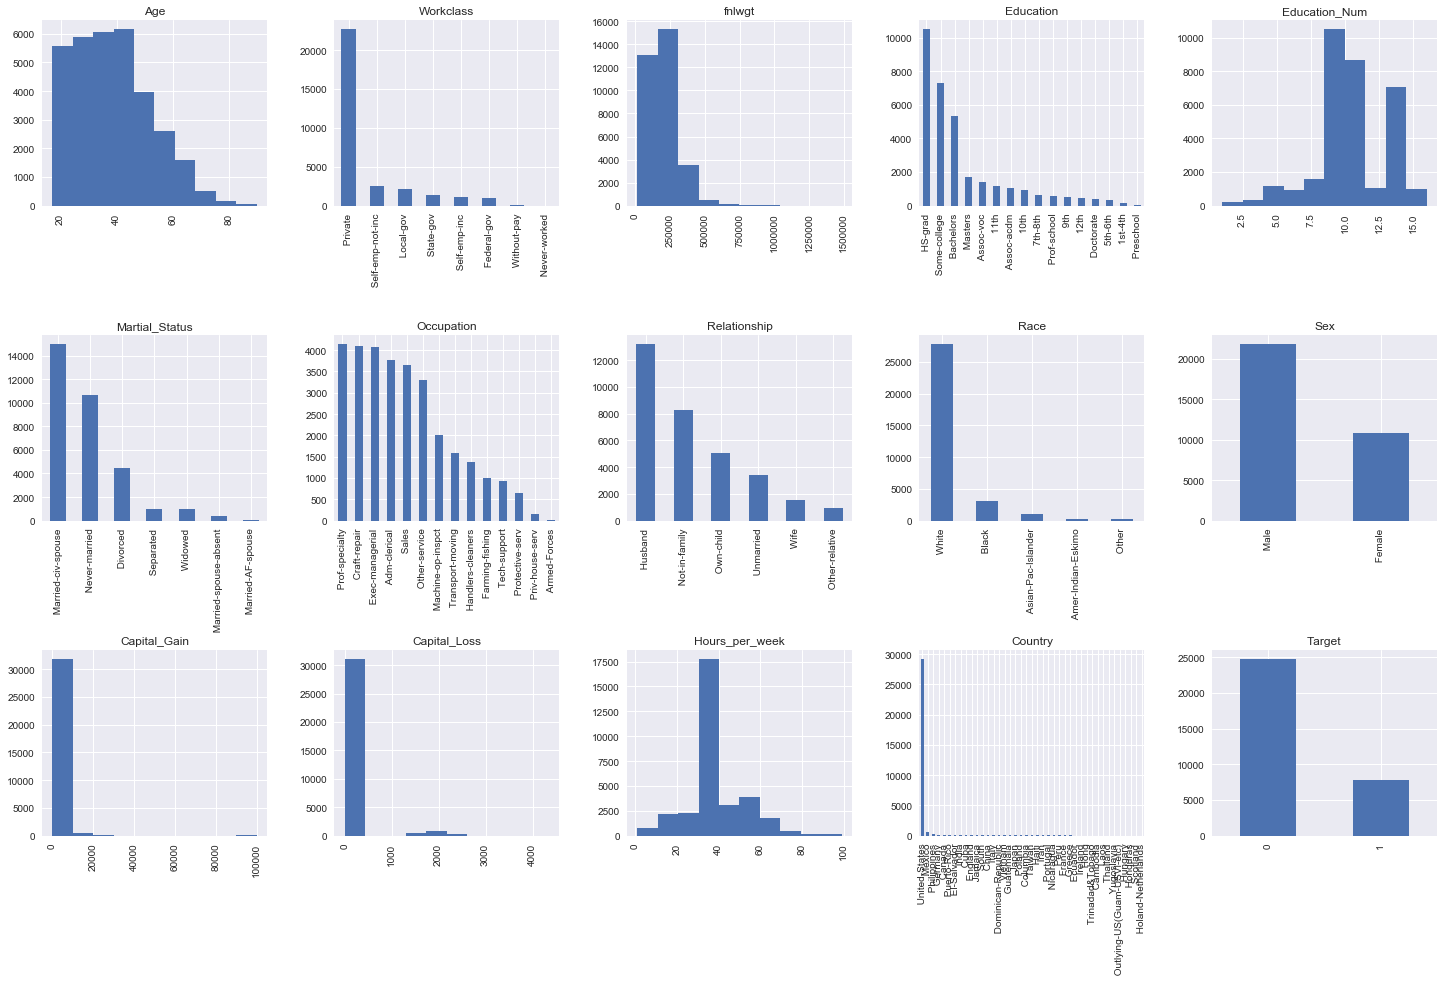

In [33]:
fig = plt.figure(figsize=(25, 15))
for i, col in enumerate(df_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(col)
    if df_train.dtypes[col] == np.object:
        df_train[col].value_counts().plot(kind='bar', axes=ax)
    else:
        df_train[col].hist(axes=ax)
        plt.xticks(rotation='vertical')
plt.subplots_adjust(hspace=0.7, wspace=0.3)
    

In [34]:
df_test.dtypes,  df_train.dtypes

(Age                object
 Workclass          object
 fnlwgt            float64
 Education          object
 Education_Num     float64
 Martial_Status     object
 Occupation         object
 Relationship       object
 Race               object
 Sex                object
 Capital_Gain      float64
 Capital_Loss      float64
 Hours_per_week    float64
 Country            object
 Target             object
 dtype: object, Age                int64
 Workclass         object
 fnlwgt             int64
 Education         object
 Education_Num      int64
 Martial_Status    object
 Occupation        object
 Relationship      object
 Race              object
 Sex               object
 Capital_Gain       int64
 Capital_Loss       int64
 Hours_per_week     int64
 Country           object
 Target            object
 dtype: object)

In [35]:
df_test['fnlwgt'] = df_test['fnlwgt'].astype(int)
df_test['Education_Num'] = df_test['Education_Num'].astype(int)
df_test['Capital_Gain'] = df_test['Capital_Gain'].astype(int)
df_test['Capital_Loss'] = df_test['Capital_Loss'].astype(int)
df_test['Hours_per_week'] = df_test['Hours_per_week'].astype(int)

#### Заполним пропуски в количественных полях медианными значениями, а в категориальных – наиболее часто встречающимся значением

In [36]:
categorical_col_train = [c for c in df_train.columns if df_train[c].dtype.name == 'object']
categorical_col_test = [c for c in df_test.columns if df_test[c].dtype.name == 'object']

In [37]:
categorical_col_test, categorical_col_train

(['Age',
  'Workclass',
  'Education',
  'Martial_Status',
  'Occupation',
  'Relationship',
  'Race',
  'Sex',
  'Country',
  'Target'],
 ['Workclass',
  'Education',
  'Martial_Status',
  'Occupation',
  'Relationship',
  'Race',
  'Sex',
  'Country',
  'Target'])

In [38]:
numeric_col_train = [c for c in df_train.columns if df_train[c].dtype.name != 'object']
numeric_col_test = [c for c in df_test.columns if df_test[c].dtype.name != 'object']

In [39]:
numeric_col_train, numeric_col_test

(['Age',
  'fnlwgt',
  'Education_Num',
  'Capital_Gain',
  'Capital_Loss',
  'Hours_per_week'],
 ['fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week'])

In [40]:
## Заполняем пропуски

for c in categorical_col_test:
    df_test[c] = df_test[c].fillna(df_test[c].mode())

for c in categorical_col_train:
    df_train[c] = df_train[c].fillna(df_train[c].mode())
    
for c in numeric_col_test:
    df_test[c] = df_test[c].fillna(df_test[c].median())

for c in numeric_col_train:
    df_train[c] = df_train[c].fillna(df_train[c].median())

#### Кодируем категориальные признаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода pandas get_dummies.

In [41]:

df_train = pd.concat([df_train, pd.get_dummies(df_train['Workclass'], prefix="Workclass"),
                      pd.get_dummies(df_train['Education'], prefix="Education"),
                      pd.get_dummies(df_train['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(df_train['Occupation'], prefix="Occupation"),
                      pd.get_dummies(df_train['Relationship'], prefix="Relationship"),
                      pd.get_dummies(df_train['Race'], prefix="Race"),
                      pd.get_dummies(df_train['Sex'], prefix="Sex"),
                      pd.get_dummies(df_train['Country'], prefix="Country")],
                     axis=1)

df_test = pd.concat([df_test, pd.get_dummies(df_test['Workclass'], prefix="Workclass"),
                      pd.get_dummies(df_test['Education'], prefix="Education"),
                      pd.get_dummies(df_test['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(df_test['Occupation'], prefix="Occupation"),
                      pd.get_dummies(df_test['Relationship'], prefix="Relationship"),
                      pd.get_dummies(df_test['Race'], prefix="Race"),
                      pd.get_dummies(df_test['Sex'], prefix="Sex"),
                      pd.get_dummies(df_test['Country'], prefix="Country")],
                     axis=1)

In [42]:
df_train.drop(['Workclass', 'Education', 'Martial_Status',
                 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
                axis=1, inplace=True)
df_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation', 
                'Relationship', 'Race', 'Sex', 'Country'],
               axis=1, inplace=True)

In [43]:
df_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281,NaN,NaN,NaN,189436,105715,13492,116736,177831,238384,1.4904e+06
Education_Num,16281,NaN,NaN,NaN,10.0729,2.56755,1,9,10,12,16
Capital_Gain,16281,NaN,NaN,NaN,1081.91,7583.94,0,0,0,0,99999
Capital_Loss,16281,NaN,NaN,NaN,87.8993,403.105,0,0,0,0,3770
Hours_per_week,16281,NaN,NaN,NaN,40.3922,12.4793,1,40,40,45,99
Target,16281,NaN,NaN,NaN,0.236226,0.424776,0,0,0,0,1
Workclass_ Federal-gov,16281,NaN,NaN,NaN,0.0289908,0.167786,0,0,0,0,1
Workclass_ Local-gov,16281,NaN,NaN,NaN,0.0640624,0.244872,0,0,0,0,1
Workclass_ Never-worked,16281,NaN,NaN,NaN,0.000184264,0.0135735,0,0,0,0,1


In [44]:
set(df_train.columns) - set(df_test.columns)

{'Country_ Holand-Netherlands'}

In [45]:
df_train.shape, df_test.shape

((32561, 106), (16281, 105))

In [46]:
### Добавляем {'Country_ Holand-Netherlands'}
df_test['Country_ Holand-Netherlands'] = np.zeros([df_test.shape[0], 1])
set(df_train.columns) - set(df_test.columns)

set()

In [48]:
X_train = df_train.drop(['Target'], axis=1)
y_train = df_train['Target']

X_test = df_test.drop(['Target'], axis=1)
y_test = df_test['Target']


### 3.1. Дерево решений без настройки параметров
Обучите на имеющейся выборке дерево решений (DecisionTreeClassifier) максимальной глубины 3 и получите качество на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.

In [49]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [50]:
tree_predict = tree.predict(X_test)
accuracy_score(y_test, tree_predict)

0.84478840366070884


### 3.2. Дерево решений с настройкой параметров
Обучите на имеющейся выборке дерево решений (DecisionTreeClassifier, опять random_state = 17 ). Максимальную глубину настройте на кросс-валидации с помощью GridSearchCV. Проведите 5-кратную кросс-валидацию

In [51]:
tree_params = {'max_depth': range(1, 11)}
tree_grid = GridSearchCV(tree, tree_params, 
                         cv=5, n_jobs=-1, 
                         verbose=True)

In [52]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 11)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=True)

In [53]:
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 9}, 0.85626977058444154)

In [55]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [56]:
tuned_tree_pred = tuned_tree.predict(X_test)
accuracy_score(y_test, tuned_tree_pred)

0.8471838339168356

### 3.3. Случайный лес без настройки параметров (опционально)¶
Немного забежим вперед и попробуем в нашей задаче случайный лес. Пока можно его себе представлять, как куча деревьев решений, обученных на немного разных подвыборках исходной обучающей выборки, причем эта куча деревьев обычно работает существенно лучше, чем отдельные деревья.
Обучите на имеющейся выборке случайный лес (RandomForestClassifier), число деревьев сделайте равным ста, а random_state = 17.

In [58]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,random_state=17)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=17,
            verbose=0, warm_start=False)

In [59]:
rf_pred = rf.predict(X_test)
accuracy_score(y_test, rf_pred)

0.85762545298200354

### 3.4. Случайный лес с настройкой параметров (опционально)
Обучите на имеющейся выборке случайный лес (RandomForestClassifier). Максимальную глубину и максимальное число признаков для каждого дерева настройте с помощью GridSearchCV.

In [61]:
forest_params = {'max_depth': range(10, 15),
                'max_features': range(5, 105, 30)}

locally_best_forest = GridSearchCV(rf, forest_params, cv=5, n_jobs=-1, verbose=True)

locally_best_forest.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=17,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(10, 15), 'max_features': range(5, 105, 30)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [62]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Best params: {'max_depth': 13, 'max_features': 65}
Best cross validaton score 0.865268265717


In [65]:
tuned_forest_predictions = locally_best_forest.predict(X_test)
accuracy_score(y_test, tuned_forest_predictions)

0.8649345863276211